In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

import pandas as pd, warnings
# warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

path_to_data_dir = "../../../data/"

def load_local_preprocessed_data():
	X_train = pd.read_csv(path_to_data_dir + "prep_X_train.csv").set_index(["date", "ticker"])
	X_val = pd.read_csv(path_to_data_dir + "prep_X_val.csv").set_index(["date", "ticker"])
	X_test = pd.read_csv(path_to_data_dir + "prep_X_test.csv").set_index(["date", "ticker"])
	target = pd.read_csv(path_to_data_dir + "s&p_adjusted_target.csv").set_index(["date", "ticker"])
	return X_train, X_val, X_test, target["change_adj_s&p"]

In [2]:
# Load data
X_train, X_val, X_test, y_series = load_local_preprocessed_data()

train_dates, val_dates, test_dates = list(map(lambda df: df.index.get_level_values(0).unique().sort_values(), [X_train, X_val, X_test]))
print(f"# of train dates ({len(train_dates)}), val dates ({len(val_dates)}), test dates ({len(test_dates)})")

y_train = y_series.loc[train_dates]
y_val = y_series.loc[val_dates]
y_test = y_series.loc[test_dates]

print(f"Train shapes: {X_train.shape, y_train.shape}")
print(f"Val shapes: {X_val.shape, y_val.shape}")
print(f"Test shapes: {X_test.shape, y_test.shape}")

# of train dates (17), val dates (5), test dates (7)
Train shapes: ((26571, 380), (26571,))
Val shapes: ((7778, 380), (7778,))
Test shapes: ((11263, 380), (11263,))


In [5]:
results_dir = "../../../results/grid_results/"

with open(results_dir + "grid_search_cv_results_moving_window.json", "r") as cv_json:
	cv_results = json.load(cv_json)

In [6]:
latest_val_date = val_dates[-1]

model_params = {}
for model_name in cv_results:
	model_params[model_name] = cv_results[model_name]["best_params"][latest_val_date]

In [7]:
all_dates = np.array(train_dates.values.tolist() + val_dates.values.tolist() + test_dates.values.tolist())
len(all_dates), all_dates[0]

(29, '2023-10-04')

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

def evaluate_test_RMSE(X_all, y_all, train_dates, val_dates, test_dates, model_algo, params, moving_train_window = False, num_states = 1):
	all_dates = np.array(train_dates.values.tolist() + val_dates.values.tolist() + test_dates.values.tolist())


	random_states_train_rmse = defaultdict(lambda: dict())
	random_states_test_rmse = defaultdict(lambda: dict())

	all_train_preds = {}
	all_test_preds = {}

	all_train_rmse = {}
	all_test_rmse = {}

	all_train_r2 = {}
	all_test_r2 = {}
	
	all_train_std = {}
	all_test_std = {}

	print(f"Total dates: {len(all_dates)}")
	# Train latest best params for 7 test dates

	# pipe = make_pipeline(model_algo)

	# pipe.set_params(**params)

	# Use time series split to prevent data leakage
	time_split = TimeSeriesSplit(n_splits=len(test_dates), test_size=1, gap=5)

	for i in range(num_states):

		pipe = make_pipeline(model_algo)
		if num_states > 1:
			pipe.set_params(**params, randomforestregressor__random_state = i)
		else:
			pipe.set_params(**params)

		for train_idxs, test_idx in tqdm(time_split.split(all_dates), total = len(test_dates)):

			if moving_train_window:
					train_idxs = train_idxs[-10:]

			train_dates = all_dates[train_idxs]
			test_date = all_dates[test_idx]

			train_set_X = X_all.loc[train_dates]
			train_set_y = y_all.loc[train_dates]

			test_set_X = X_all.loc[test_date]
			test_set_y = y_all.loc[test_date]

			pipe.fit(train_set_X, train_set_y)

			truths = [train_set_y, test_set_y]

			preds = list(map(lambda v: pipe.predict(v), [train_set_X, test_set_X]))

			train_rmse, test_rmse = list(
				map(
					lambda x: mean_squared_error(x[0], x[1], squared=False),
					zip(truths, preds)))

			train_r2, test_r2 = list(
				map(
					lambda x: r2_score(x[0], x[1]),
					zip(truths, preds)))
			
			train_stddev, test_stddev = list(
				map(
					lambda pred: pred.std(),
					preds))
			
			# print(f"RMSE:")
			# print(f"Train: {train_rmse:.6f}")
			# print(f"Test: {test_rmse:.6f}")
			# print(f"R2:")
			# print(f"Train: {train_r2:.6f}")
			# print(f"Test: {test_r2:.6f}")
			# print(f"Stddev:")
			# print(f"Train: {train_stddev:.6f}")
			# print(f"Test: {test_stddev:.6f}")

			all_train_preds[test_date[0]], all_test_preds[test_date[0]] = preds
			all_train_rmse[test_date[0]], all_test_rmse[test_date[0]] = train_rmse, test_rmse
			all_train_r2[test_date[0]], all_test_r2[test_date[0]] = train_r2, test_r2
			all_train_std[test_date[0]], all_test_std[test_date[0]] = train_stddev, test_stddev
			random_states_train_rmse[i][test_date[0]] = train_rmse
			random_states_test_rmse[i][test_date[0]] = test_rmse

	return {
		"train_rmse": all_train_rmse,
		"test_rmse": all_test_rmse,
		"train_r2": all_train_r2,
		"test_r2": all_test_r2,
		"train_std": all_train_std,
		"test_std": all_test_std
	}, {"train": all_train_preds, "test": all_test_preds}, pipe, {"train": random_states_train_rmse, "test": random_states_test_rmse}


In [9]:
X_all = pd.concat([X_train, X_val, X_test], axis = 0)
y_all = pd.concat([y_train, y_val, y_test], axis = 0)
X_all.shape, y_all.shape

((45612, 380), (45612,))

In [10]:
model_params

{'linearregression': {},
 'elasticnet': {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.01},
 'bayesianridge': {'bayesianridge__alpha_1': 0.01,
  'bayesianridge__alpha_2': 1e-10,
  'bayesianridge__lambda_1': 1e-10,
  'bayesianridge__lambda_2': 1e-05},
 'kneighborsregressor': {'kneighborsregressor__n_neighbors': 1000,
  'kneighborsregressor__weights': 'uniform'},
 'randomforestregressor': {'randomforestregressor__criterion': 'friedman_mse',
  'randomforestregressor__max_features': 'log2',
  'randomforestregressor__n_estimators': 250,
  'randomforestregressor__max_samples': 0.5}}

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor


models = [
	("linearregression", LinearRegression()),
	("elasticnet", ElasticNet()),
	("bayesianridge", BayesianRidge()),
	("kneighborsregressor", KNeighborsRegressor()),
	("randomforestregressor", RandomForestRegressor()),
	# ("adaboostregressor", AdaBoostRegressor())
]

result_dfs = []
all_preds = {}
all_models = {}

random_states_results_all = {}

for model_name, model_algo in models:
	print(model_name)
	result_dict, model_preds, trained_model, random_states_results = evaluate_test_RMSE(
		X_all, y_all, train_dates, val_dates, test_dates,
		model_algo, model_params[model_name], moving_train_window=True, num_states = 1 if model_name != "randomforestregressor" else 5)
	
	# Create result df and add to pile
	result_df = pd.DataFrame(result_dict).add_prefix(model_name + "_")
	result_dfs.append(result_df)
	all_preds[model_name] = model_preds
	all_models[model_name] = trained_model
	random_states_results_all[model_name] = random_states_results


linearregression
Total dates: 29


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


elasticnet
Total dates: 29


100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


bayesianridge
Total dates: 29


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


kneighborsregressor
Total dates: 29


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


randomforestregressor
Total dates: 29


100%|██████████| 7/7 [02:02<00:00, 17.52s/it]


In [12]:
train_random_states_df = pd.DataFrame(random_states_results_all["randomforestregressor"]["train"])
test_random_states_df = pd.DataFrame(random_states_results_all["randomforestregressor"]["test"])

In [13]:
def calc_mean_std_random_states(random_states_df):
	mean_ = random_states_df.mean(axis = 0)
	std_ = random_states_df.std(axis = 0)
	return pd.DataFrame({"mean": mean_, "std": std_})

In [14]:
test_mean_std_df_rf = calc_mean_std_random_states(test_random_states_df.T)
test_mean_std_df_rf

,mean,std
2023-11-06,0.066172,0.000117
2023-11-07,0.065955,0.000163
2023-11-08,0.060228,0.000110
2023-11-09,0.060301,0.000102
2023-11-10,0.064457,0.000059
2023-11-13,0.065009,0.000078
2023-11-14,0.087479,0.000170


In [15]:
total_result_df = pd.concat(result_dfs, axis = 1)

In [16]:
# Get baseline results
moving_train_window = True

time_split = TimeSeriesSplit(n_splits=len(test_dates), test_size=1, gap=5)

all_dates = np.array(train_dates.tolist() + val_dates.tolist() + test_dates.tolist())

baseline_train_rmse_scores = {}
baseline_test_rmse_scores = {}
baseline_train_r2_scores = {}
baseline_test_r2_scores = {}
baseline_train_std_scores = {}
baseline_test_std_scores = {}

for train_idxs, test_idx in time_split.split(all_dates):
	
	if moving_train_window:
		train_idxs = train_idxs[-10:]

	train_dates = all_dates[train_idxs]
	test_date = all_dates[test_idx]

	train_set_X = X_all.loc[train_dates]
	train_set_y = y_all.loc[train_dates]

	test_set_X = X_all.loc[test_date]
	test_set_y = y_all.loc[test_date]

	baseline_pred = train_set_y.median()

	baseline_train_rmse = mean_squared_error(train_set_y.values, baseline_pred * np.ones_like(train_set_y.values), squared=False)
	baseline_test_rmse = mean_squared_error(test_set_y.values, baseline_pred * np.ones_like(test_set_y.values), squared=False)

	baseline_train_r2 = r2_score(train_set_y.values, baseline_pred * np.ones_like(train_set_y.values))
	baseline_test_r2 = r2_score(test_set_y.values, baseline_pred * np.ones_like(test_set_y.values))

	baseline_train_rmse_scores[test_date[0]], baseline_test_rmse_scores[test_date[0]] = baseline_train_rmse, baseline_test_rmse
	baseline_train_r2_scores[test_date[0]], baseline_test_r2_scores[test_date[0]] = baseline_train_r2, baseline_test_r2
	baseline_train_std_scores[test_date[0]], baseline_test_std_scores[test_date[0]] = 0.0, 0.0

baseline_results_df = pd.DataFrame({
		"train_rmse": baseline_train_rmse_scores,
		"test_rmse": baseline_test_rmse_scores,
		"train_r2": baseline_train_r2_scores,
		"test_r2": baseline_test_r2_scores,
		"train_std": baseline_train_std_scores,
		"test_std": baseline_test_std_scores
	})

In [17]:
total_result_df.mean(axis = 0)[total_result_df.columns[total_result_df.columns.str.contains("_test_rmse")]]

linearregression_test_rmse         0.105634
elasticnet_test_rmse               0.064945
bayesianridge_test_rmse            0.065255
kneighborsregressor_test_rmse      0.065085
randomforestregressor_test_rmse    0.067134
dtype: float64

In [18]:
total_result_df[total_result_df.columns[total_result_df.columns.str.contains("_test_rmse")]]

,linearregression_test_rmse,elasticnet_test_rmse,bayesianridge_test_rmse,kneighborsregressor_test_rmse,randomforestregressor_test_rmse
2023-11-06,0.070274,0.065806,0.065765,0.066692,0.066333
2023-11-07,0.067048,0.063516,0.063265,0.064116,0.065868
2023-11-08,0.059252,0.057134,0.057511,0.057065,0.060324
2023-11-09,0.061593,0.058060,0.057972,0.057932,0.060147
2023-11-10,0.069170,0.063456,0.063909,0.063790,0.064541
2023-11-13,0.194883,0.062187,0.062701,0.062215,0.065019
2023-11-14,0.217217,0.084454,0.085665,0.083785,0.087710


In [15]:
import shap
shap.initjs()

def make_global_and_local_shap_plots_linear(model_name, index = 0):
	explainer = shap.Explainer(all_models[model_name][0], train_set_X)
	shap_values = explainer.shap_values(test_set_X)
	shap.force_plot(
		explainer.expected_value,
		shap_values[index,:],
		features = np.around(test_set_X.iloc[index], decimals = 2),
		feature_names = test_set_X.columns,
		matplotlib = True)
	
	feature_names = test_set_X.columns
	top_10_important_ftr_indices = np.argsort(-abs(shap_values).mean(axis = 0))[:10]
	shap_10_important_features = feature_names[top_10_important_ftr_indices]
	shap.summary_plot(
		shap_values[:, top_10_important_ftr_indices],
		test_set_X[shap_10_important_features],
		feature_names = shap_10_important_features)
	
def make_global_and_local_shap_plots_tree(model_name, index = 0):
	explainer = shap.TreeExplainer(all_models[model_name][0])
	shap_values = explainer.shap_values(test_set_X.iloc[index, :])
	shap.force_plot(
		explainer.expected_value,
		shap_values.reshape((1, -1)),
		features = np.around(test_set_X.iloc[index], decimals = 2),
		feature_names = test_set_X.columns,
		matplotlib = True)
	
	feature_names = test_set_X.columns
	top_10_important_ftr_indices = np.argsort(-abs(shap_values).mean(axis = 0))[:10]
	shap_10_important_features = feature_names[top_10_important_ftr_indices]
	shap.summary_plot(
		shap_values[top_10_important_ftr_indices].reshape((1, -1)),
		test_set_X[shap_10_important_features],
		feature_names = shap_10_important_features)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


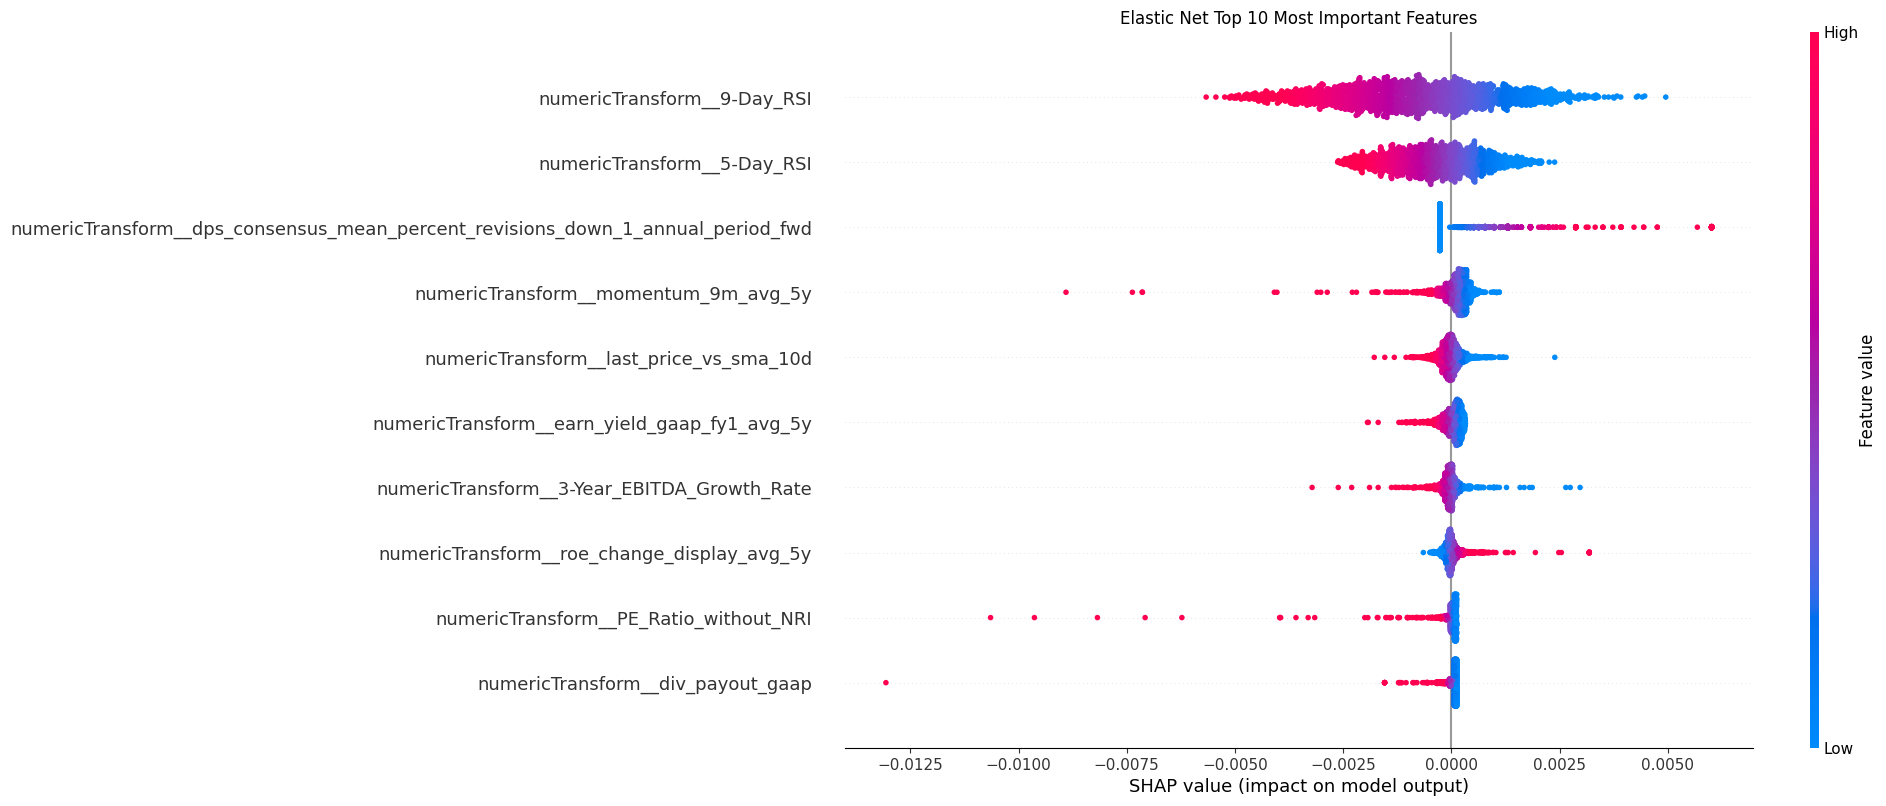

In [39]:
import matplotlib.pyplot as plt

index = 0

explainer = shap.Explainer(all_models["elasticnet"][0], train_set_X)
shap_values = explainer.shap_values(test_set_X)
# shap.force_plot(
# 	explainer.expected_value,
# 	shap_values[index,:],
# 	features = np.around(test_set_X.iloc[index], decimals = 2),
# 	feature_names = test_set_X.columns,
# 	matplotlib = True)

feature_names = test_set_X.columns
top_10_important_ftr_indices = np.argsort(-abs(shap_values).mean(axis = 0))[:10]
shap_10_important_features = feature_names[top_10_important_ftr_indices]
shap.summary_plot(
	shap_values[:, top_10_important_ftr_indices],
	test_set_X[shap_10_important_features],
	feature_names = shap_10_important_features, show = False, plot_size = (20, 8))
plt.title("Elastic Net Top 10 Most Important Features")
plt.savefig("elasticnet_shap.png", dpi = 300)

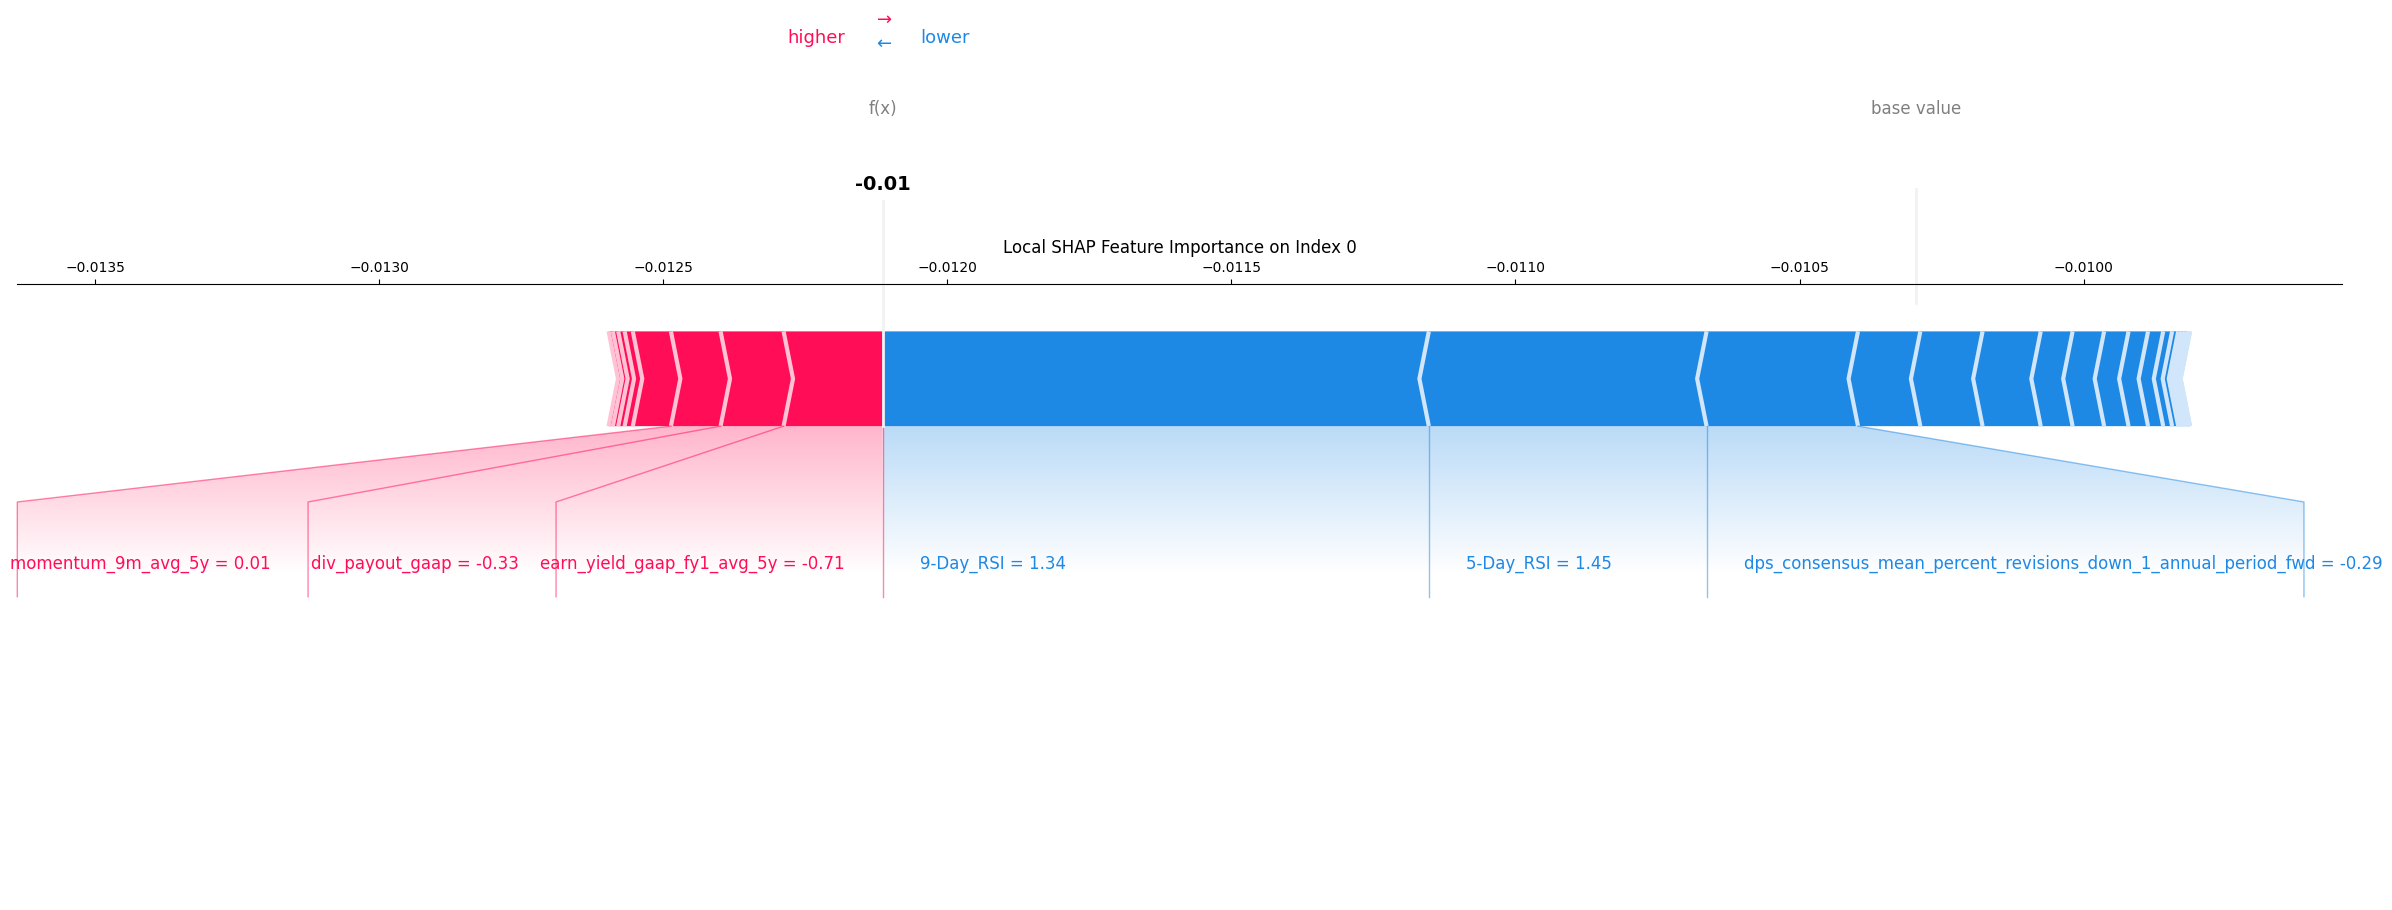

In [22]:
index = 0

explainer = shap.Explainer(all_models["elasticnet"][0], train_set_X)
shap_values = explainer.shap_values(test_set_X)
shap.force_plot(
	explainer.expected_value,
	shap_values[index,:],
	features = np.around(test_set_X.iloc[index], decimals = 2),
	feature_names = test_set_X.columns.str.replace("numericTransform__", "", regex = False), matplotlib = True, show = False, figsize = (30, 8))

plt.title(f"Local SHAP Feature Importance on Index {index}")
plt.savefig("elasticnet_local.png", dpi=300)
plt.show()

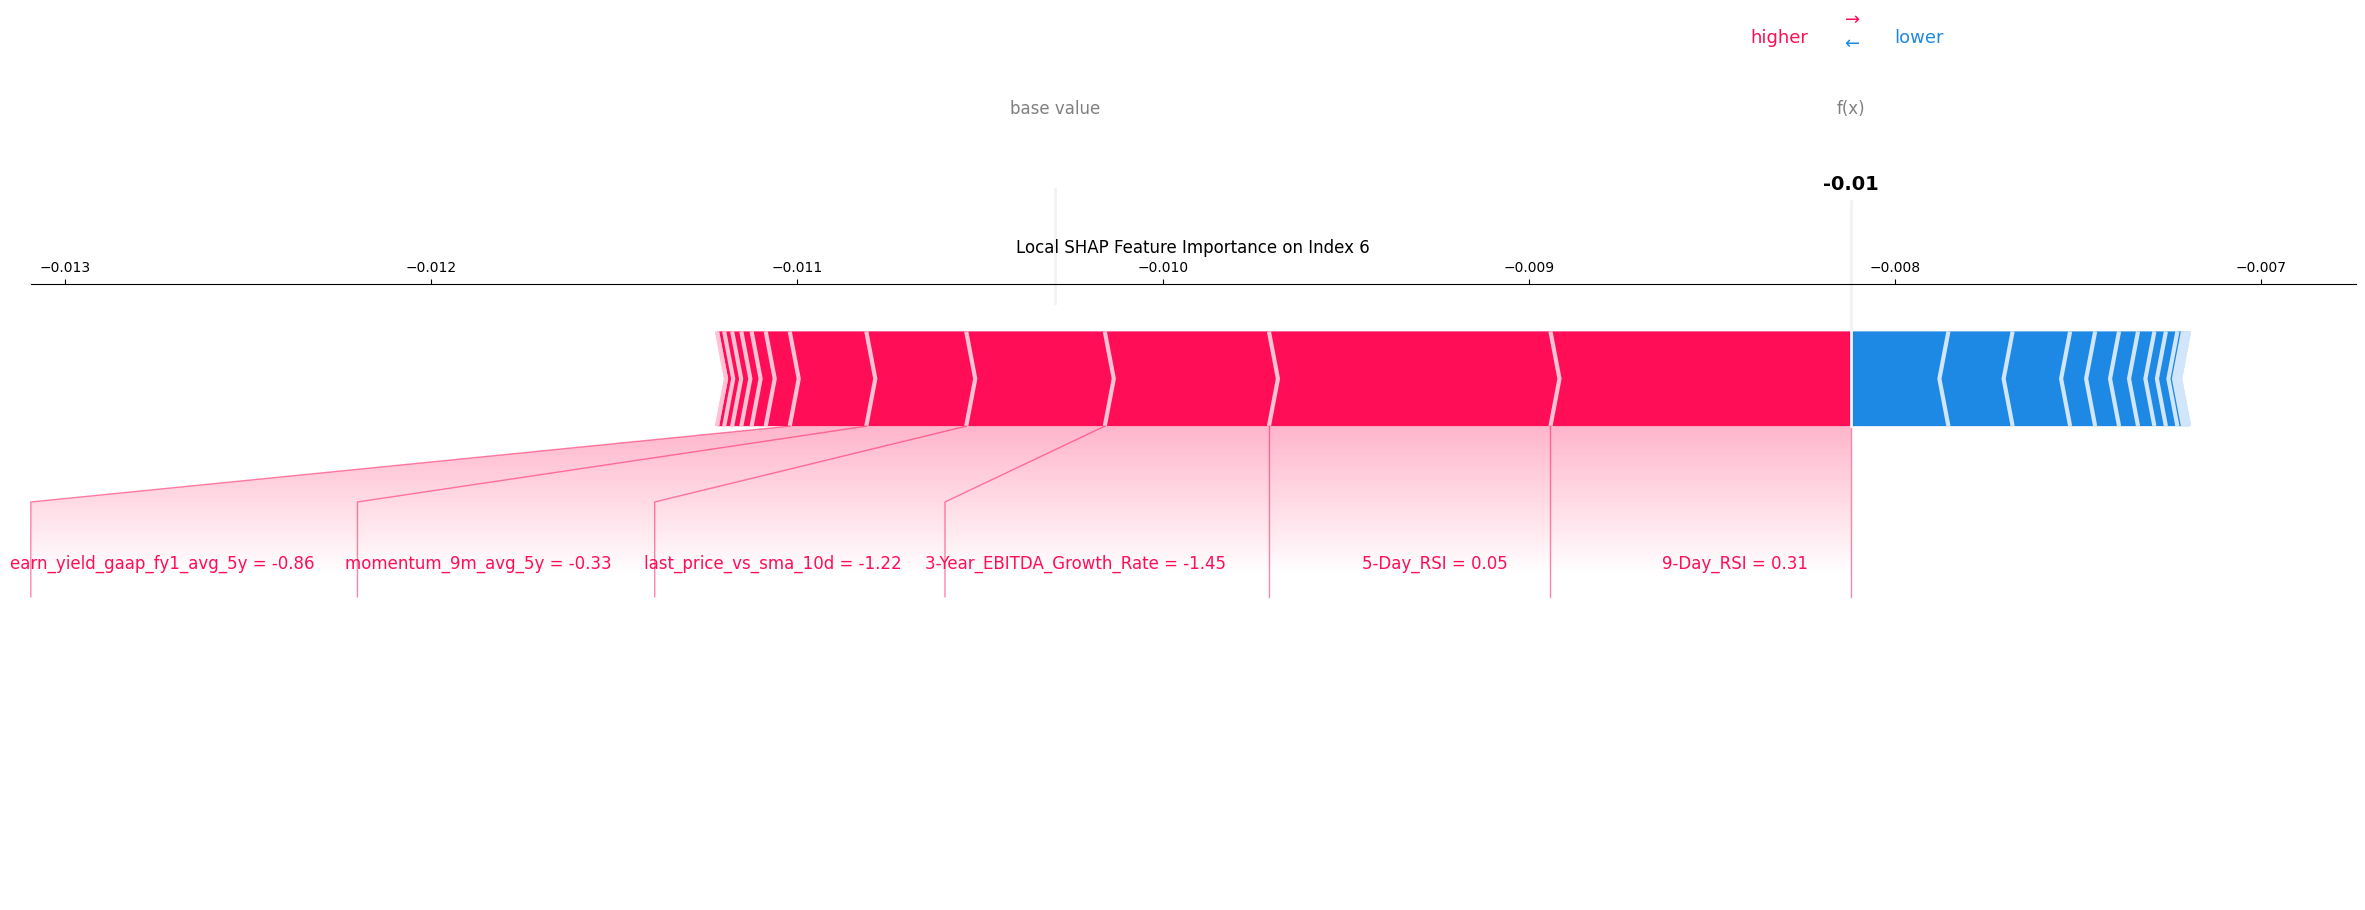

In [41]:
index = 6

explainer = shap.Explainer(all_models["elasticnet"][0], train_set_X)
shap_values = explainer.shap_values(test_set_X)
shap.force_plot(
	explainer.expected_value,
	shap_values[index,:],
	features = np.around(test_set_X.iloc[index], decimals = 2),
	feature_names = test_set_X.columns.str.replace("numericTransform__", "", regex = False), matplotlib = True, show = False, figsize = (30, 8))

plt.title(f"Local SHAP Feature Importance on Index {index}")
plt.savefig("elasticnet_local_2.png", dpi=300)
plt.show()

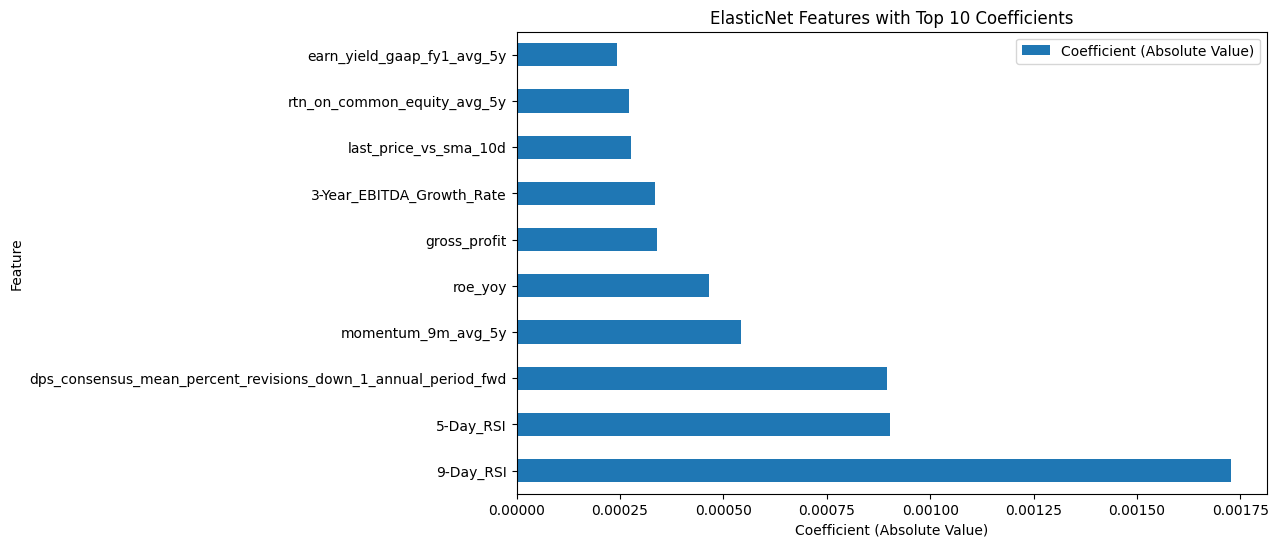

In [40]:
pd.DataFrame(
	list(zip(test_set_X.columns.str.replace("numericTransform__", "", regex = False), abs(all_models["elasticnet"][0].coef_))),
	columns = ["Feature", "Coefficient (Absolute Value)"]
	).set_index("Feature").sort_values("Coefficient (Absolute Value)", ascending=False).head(10).plot(kind = "barh", figsize=(15, 6))
plt.title("ElasticNet Features with Top 10 Coefficients")
plt.xlabel("Coefficient (Absolute Value)")
plt.subplots_adjust(left = 0.4)
plt.savefig("elasticnet_coef.png", dpi = 300)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


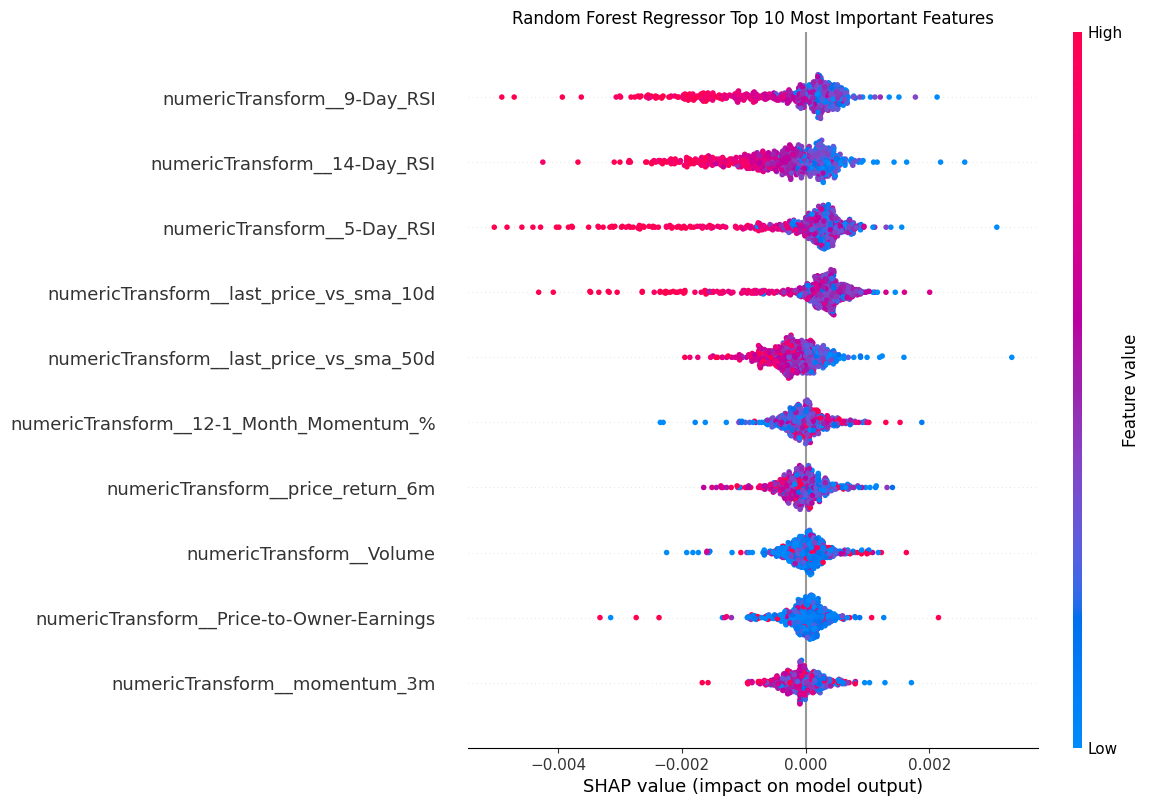

In [52]:
index = 0

explainer = shap.TreeExplainer(all_models["randomforestregressor"][0])
shap.initjs()
shap_values = explainer.shap_values(test_set_X.iloc[index:(index+500), :], approximate=True)
# shap.force_plot(
# 	explainer.expected_value,
# 	shap_values,
# 	features = np.around(test_set_X.iloc[index], decimals = 2),
# 	feature_names = test_set_X.columns)

feature_names = test_set_X.columns
top_10_important_ftr_indices = np.argsort(-abs(shap_values).mean(axis = 0))[:10]
shap_10_important_features = feature_names[top_10_important_ftr_indices]
shap.summary_plot(
	shap_values[:, top_10_important_ftr_indices],
	test_set_X.iloc[index:(index+500), :][shap_10_important_features],
	feature_names = shap_10_important_features, show = False, plot_size = (12, 8))
plt.title("Random Forest Regressor Top 10 Most Important Features")
plt.savefig("randomforestregressor_shap.png", dpi = 300)

In [44]:
knn = all_models["kneighborsregressor"][0]

def f(x):
    return knn.predict(x)

med = train_set_X.median().to_frame().T# .values.reshape((1, train_set_X.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(test_set_X, max_evals = 1000)
# shap.force_plot(explainer.expected_value, shap_values[index,:], features = np.around(test_set_X.iloc[index], decimals = 2), feature_names = test_set_X.columns, matplotlib = True)

Permutation explainer: 1608it [03:03,  8.35it/s]                          


In [48]:
shap_values = shap_values.values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


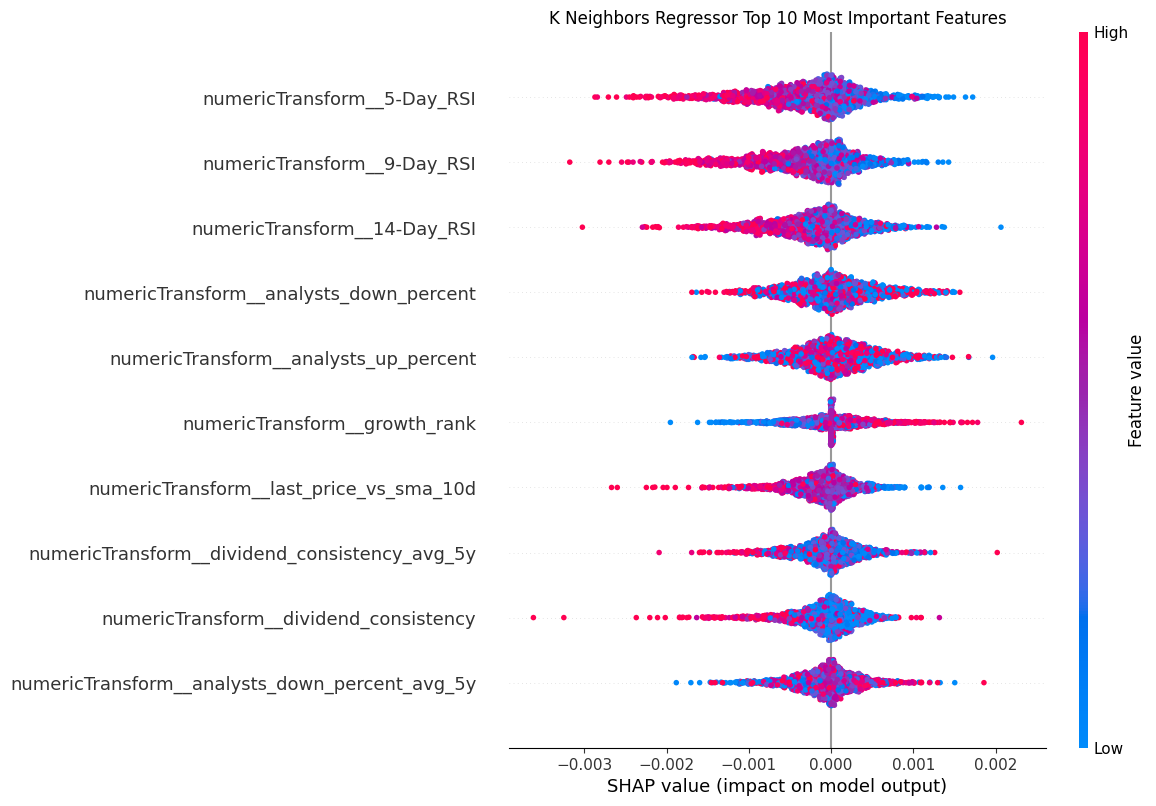

In [51]:
feature_names = test_set_X.columns
top_10_important_ftr_indices = np.argsort(-abs(shap_values).mean(axis = 0))[:10]
shap_10_important_features = feature_names[top_10_important_ftr_indices]
shap.summary_plot(
	shap_values[:, top_10_important_ftr_indices],
	test_set_X[shap_10_important_features],
	feature_names = shap_10_important_features, show = False, plot_size = (12, 8))
plt.title("K Neighbors Regressor Top 10 Most Important Features")
plt.savefig("kneighborsregressor_shap.png", dpi = 300)

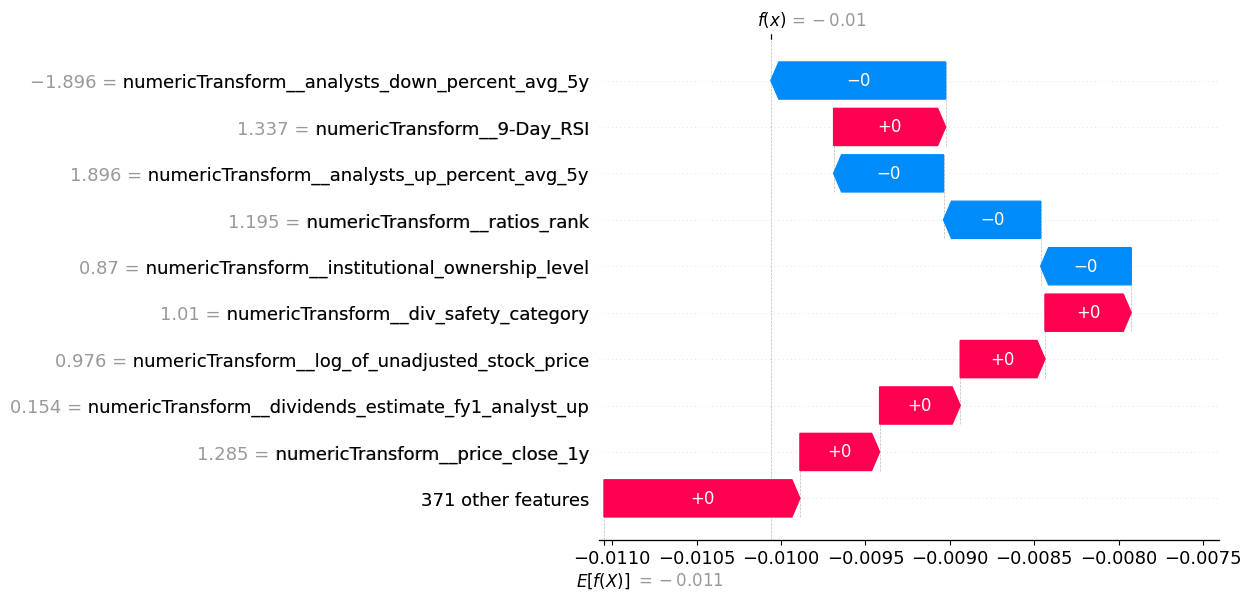

In [33]:
shap.plots.waterfall(shap_values[0])

In [15]:
xgb_results_df = pd.read_csv("xgbregressor_results.csv").set_index("Unnamed: 0")
xgb_results_df

,xgbregressor_train_rmse,xgbregressor_test_rmse,xgbregressor_train_r2,xgbregressor_test_r2,xgbregressor_train_std,xgbregressor_test_std
Unnamed: 0,,,,,,
2023-11-06,0.051010,0.065215,0.157665,-0.055642,0.008821,0.006944
2023-11-07,0.054068,0.063593,0.136897,-0.185806,0.007722,0.005923
2023-11-08,0.055838,0.056425,0.132736,-0.027845,0.007644,0.005268
2023-11-09,0.057097,0.055573,0.159039,0.004507,0.010183,0.010041
2023-11-10,0.058196,0.057301,0.183508,-0.020675,0.012751,0.012176
2023-11-13,0.059897,0.058664,0.164303,-0.041238,0.011314,0.010082
2023-11-14,0.061200,0.080662,0.164992,-0.623876,0.011069,0.009239


In [20]:
xgb_test_random_states_df = pd.read_csv(results_dir + "../xgb_random_state_tests/xgb_random_state_results.csv").set_index("Unnamed: 0")

In [21]:
xgb_test_mean_std_df = calc_mean_std_random_states(xgb_test_random_states_df.T)

In [22]:
all_results_df = pd.concat([baseline_results_df.add_prefix("baseline_"), total_result_df, xgb_test_mean_std_df.rename({"mean": "xgbregressor_test_rmse"}, axis = 1).drop("std", axis = 1)], axis = 1)
all_results_df.head()

,baseline_train_rmse,baseline_test_rmse,baseline_train_r2,baseline_test_r2,baseline_train_std,baseline_test_std,linearregression_train_rmse,linearregression_test_rmse,linearregression_train_r2,linearregression_test_r2,...,kneighborsregressor_test_r2,kneighborsregressor_train_std,kneighborsregressor_test_std,randomforestregressor_train_rmse,randomforestregressor_test_rmse,randomforestregressor_train_r2,randomforestregressor_test_r2,randomforestregressor_train_std,randomforestregressor_test_std,xgbregressor_test_rmse
2023-11-06,0.055635,0.067653,-0.002014,-0.136048,0.0,0.0,0.054607,0.070274,0.034666,-0.225775,...,-0.104015,0.001730,0.001762,0.034660,0.066333,0.611105,-0.092141,0.027011,0.014422,0.065241
2023-11-07,0.058221,0.065049,-0.000763,-0.240737,0.0,0.0,0.057273,0.067048,0.031538,-0.318158,...,-0.205407,0.001676,0.001699,0.036781,0.065868,0.600585,-0.272163,0.027591,0.016961,0.063601
2023-11-08,0.059965,0.056765,-0.000232,-0.040271,0.0,0.0,0.058961,0.059252,0.032998,-0.133438,...,-0.051290,0.001570,0.001599,0.037175,0.060324,0.615587,-0.174797,0.029468,0.018071,0.056491
2023-11-09,0.062264,0.057841,-0.000034,-0.078409,0.0,0.0,0.061060,0.061593,0.038255,-0.222854,...,-0.081801,0.001719,0.001709,0.037876,0.060147,0.629933,-0.166094,0.031604,0.019167,0.055549
2023-11-10,0.064406,0.063803,-0.000058,-0.265482,0.0,0.0,0.063045,0.069170,0.041759,-0.487320,...,-0.264967,0.001973,0.002047,0.038589,0.064541,0.641000,-0.294901,0.033419,0.020638,0.057295


In [23]:
rmse_df = all_results_df[all_results_df.columns[all_results_df.columns.str.contains("_test_rmse")]]

In [24]:
rmse_df.columns = rmse_df.columns.str.replace("_test_rmse", repl = "", regex = False)
rmse_df = rmse_df.reindex(rmse_df.mean(axis = 0).sort_values().index, axis = 1)

In [25]:
formatted_rmse_df = pd.concat([rmse_df[["baseline"]], rmse_df.drop("baseline", axis = 1)], axis = 1)

In [26]:
styled_df = formatted_rmse_df.style.background_gradient(cmap='Blues', axis = 1).format(precision = 3)
styled_df

,baseline,xgbregressor,elasticnet,kneighborsregressor,bayesianridge,randomforestregressor,linearregression
2023-11-06,0.068,0.065,0.066,0.067,0.066,0.066,0.070
2023-11-07,0.065,0.064,0.064,0.064,0.063,0.066,0.067
2023-11-08,0.057,0.056,0.057,0.057,0.058,0.060,0.059
2023-11-09,0.058,0.056,0.058,0.058,0.058,0.060,0.062
2023-11-10,0.064,0.057,0.063,0.064,0.064,0.065,0.069
2023-11-13,0.062,0.059,0.062,0.062,0.063,0.065,0.195
2023-11-14,0.084,0.081,0.084,0.084,0.086,0.088,0.217


In [27]:
formatted_rmse_df.style.format(precision=3).to_latex(position="h", position_float="centering",
    hrules=True, label="table:5", caption="Styled LaTeX Table",
    multirow_align="t", multicol_align="r")

'\\begin{table}[h]\n\\centering\n\\caption{Styled LaTeX Table}\n\\label{table:5}\n\\begin{tabular}{lrrrrrrr}\n\\toprule\n & baseline & xgbregressor & elasticnet & kneighborsregressor & bayesianridge & randomforestregressor & linearregression \\\\\n\\midrule\n2023-11-06 & 0.068 & 0.065 & 0.066 & 0.067 & 0.066 & 0.066 & 0.070 \\\\\n2023-11-07 & 0.065 & 0.064 & 0.064 & 0.064 & 0.063 & 0.066 & 0.067 \\\\\n2023-11-08 & 0.057 & 0.056 & 0.057 & 0.057 & 0.058 & 0.060 & 0.059 \\\\\n2023-11-09 & 0.058 & 0.056 & 0.058 & 0.058 & 0.058 & 0.060 & 0.062 \\\\\n2023-11-10 & 0.064 & 0.057 & 0.063 & 0.064 & 0.064 & 0.065 & 0.069 \\\\\n2023-11-13 & 0.062 & 0.059 & 0.062 & 0.062 & 0.063 & 0.065 & 0.195 \\\\\n2023-11-14 & 0.084 & 0.081 & 0.084 & 0.084 & 0.086 & 0.088 & 0.217 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [28]:
styled_df.to_html("styled_rmse.html")

In [29]:
xgb_test_random_states_df.min(axis = 0).mean()

0.055549026458601436

In [30]:
rmse_df.min(axis = 0)

xgbregressor             0.055549
elasticnet               0.057134
kneighborsregressor      0.057065
bayesianridge            0.057511
baseline                 0.056765
randomforestregressor    0.060147
linearregression         0.059252
dtype: float64

In [34]:
# Plot best score and std

plot_mean_std_df = pd.DataFrame([rmse_df.min(axis = 0), pd.Series(np.zeros(rmse_df.shape[0],), index = rmse_df.columns)], index = ["Best Test Score", "Standard Deviation"]).T
plot_mean_std_df.loc["xgbregressor"]["Best Test Score"] = xgb_test_random_states_df.min(axis = 0).mean()
plot_mean_std_df.loc["xgbregressor"]["Standard Deviation"] = xgb_test_random_states_df.min(axis = 0).std()
plot_mean_std_df.loc["randomforestregressor"]["Best Test Score"] = test_random_states_df.min(axis = 0).mean()
plot_mean_std_df.loc["randomforestregressor"]["Standard Deviation"] = test_random_states_df.min(axis = 0).std()
plot_mean_std_df

,Best Test Score,Standard Deviation
xgbregressor,0.055549,0.000020
elasticnet,0.057134,0.000000
kneighborsregressor,0.057065,0.000000
bayesianridge,0.057511,0.000000
baseline,0.056765,0.000000
randomforestregressor,0.060186,0.000088
linearregression,0.059252,0.000000


In [35]:
plot_mean_std_df.style.background_gradient(cmap='Blues').format(precision = 5)

,Best Test Score,Standard Deviation
xgbregressor,0.05555,0.00002
elasticnet,0.05713,0.00000
kneighborsregressor,0.05706,0.00000
bayesianridge,0.05751,0.00000
baseline,0.05676,0.00000
randomforestregressor,0.06019,0.00009
linearregression,0.05925,0.00000


In [36]:
mean_std_df = pd.DataFrame([rmse_df.mean(axis = 0), rmse_df.std(axis = 0)], index = ["Mean Test Score", "Standard Deviation"]).T
mean_std_df.style.background_gradient(cmap='Blues').format(precision = 3)

,Mean Test Score,Standard Deviation
xgbregressor,0.062,0.009
elasticnet,0.065,0.009
kneighborsregressor,0.065,0.009
bayesianridge,0.065,0.010
baseline,0.065,0.009
randomforestregressor,0.067,0.009
linearregression,0.106,0.069


In [37]:
baseline_mean_std_df = plot_mean_std_df.loc["baseline"]
plot_mean_std_df = plot_mean_std_df.drop(["bayesianridge", "baseline"], axis = 0)

In [38]:
mean_std_df.style.background_gradient(cmap='Blues').format(precision = 3).to_html("msdf.html")

In [66]:
# print(mean_std_df.style.format(precision = 3).to_latex(position="h", position_float="centering",
#     hrules=True, label="table:5", caption="Mean and Standard Deviation for Model Test Scores",
#     multirow_align="t", multicol_align="r"))

\begin{table}[h]
\centering
\caption{Mean and Standard Deviation for Model Test Scores}
\label{table:5}
\begin{tabular}{lrr}
\toprule
 & Mean Test Score & Standard Deviation \\
\midrule
xgbregressor & 0.062 & 0.009 \\
elasticnet & 0.065 & 0.009 \\
kneighborsregressor & 0.065 & 0.009 \\
bayesianridge & 0.065 & 0.010 \\
baseline & 0.065 & 0.009 \\
randomforestregressor & 0.067 & 0.009 \\
linearregression & 0.106 & 0.069 \\
\bottomrule
\end{tabular}
\end{table}



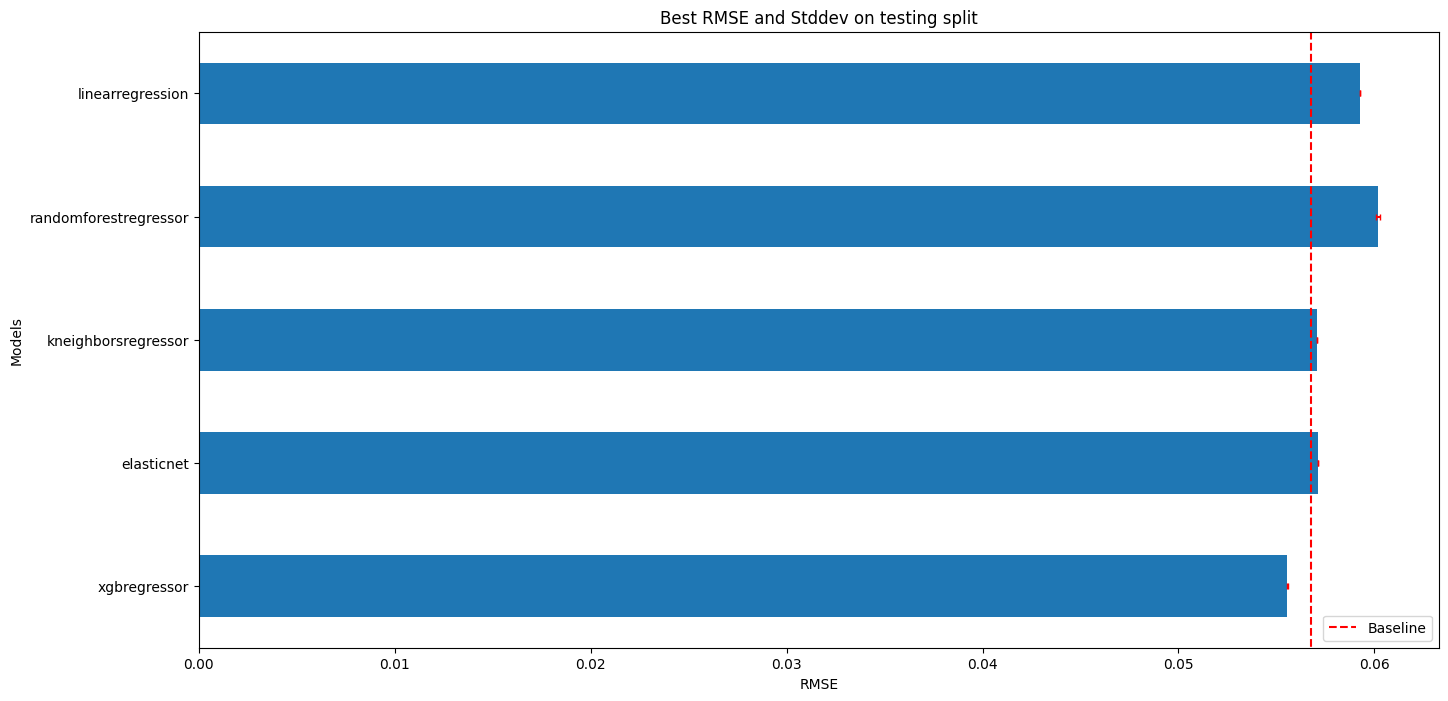

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plot_mean_std_df.rename({"Best Test Score": "_Best Test Score"}, axis = 1)["_Best Test Score"].plot(kind = "barh", legend = False)
# plt.barh(, width =2)
plt.errorbar(plot_mean_std_df["Best Test Score"], [i for i in range(plot_mean_std_df.shape[0])], xerr = plot_mean_std_df["Standard Deviation"], linestyle="None", capsize=2, c = "red")
plt.yticks(ticks = [i for i in range(plot_mean_std_df.shape[0])], labels = plot_mean_std_df.index.values)
plt.title("Best RMSE and Stddev on testing split")
plt.xlabel("RMSE")
plt.ylabel("Models")
plt.vlines(baseline_mean_std_df["Best Test Score"], ymin=-5, ymax=5, linestyles="dashed", colors="red", label = "Baseline")
# plt.xlim((0.055, 0.062))
# plt.subplots_adjust(left = -5)
plt.legend()
plt.savefig("rmse_mean_stddev.png", dpi = 300)

In [56]:
baseline_mean_std_df

Best Test Score       0.056765
Standard Deviation    0.000000
Name: baseline, dtype: float64

In [50]:
from sklearn.inspection import permutation_importance

# all_models["elasticnet"][1]

perm = permutation_importance(all_models["elasticnet"], test_set_X, test_set_y, scoring = "neg_root_mean_squared_error")

In [56]:
scores = perm["importances"]
ftr_names = test_set_X.columns.str.replace("numericTransform__", "", regex = False).values
test_score = mean_squared_error(all_models["elasticnet"].predict(test_set_X), test_set_y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


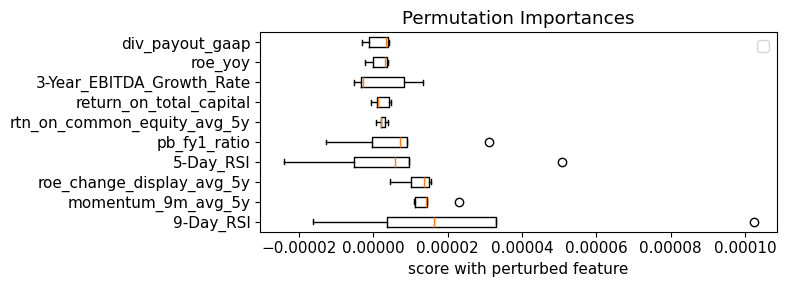

In [58]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
sorted_indcs = sorted_indcs[:10]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(8,3))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
# plt.axvline(test_score,label='test score')
plt.title("Permutation Importances")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig("elasticnet_perm.png", dpi=300)
plt.show()

(0.05, 0.1)

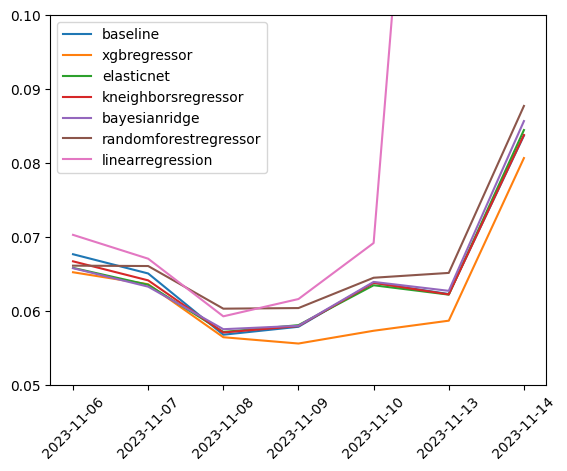

In [26]:
formatted_rmse_df.plot(kind = "line")
plt.xticks(rotation = 45)
plt.ylim(0.05, 0.1)